<a href="https://colab.research.google.com/github/jpatra72/Advanced_ML/blob/main/Variational_AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational AutoEncoder

Task:
1. Build a variational autoencoder and train the model on MNIST dataset. Also visualize the reconstructed images and the latent space embedding.

Import the installed packages

In [1]:
import os

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
import random

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from sklearn.manifold import TSNE
from torch import optim
from torch.autograd import Variable
from torch.nn.functional import binary_cross_entropy, mse_loss, softplus
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.utils import make_grid

from tqdm.notebook import tqdm

### Set a random seed for reproducibility

In [2]:
seed = 12
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
print("Random Seed: ", seed)

Random Seed:  12


Use GPU if available to accelerate training

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Helper Function to Visualize embeddings

In [20]:
def generate_visualisation(latent, labels):
    latent_embedded = TSNE(n_components=2).fit_transform(latent)
    N = 10
    plt.figure(figsize=(8, 6))
    plt.scatter(
        latent_embedded[:, 0],
        latent_embedded[:, 1],
        c=labels,
        marker="o",
        edgecolor="none",
        cmap="Spectral",
    )
    plt.colorbar(boundaries=np.arange(N + 1) - 0.5).set_ticks(np.arange(N))
    plt.grid(True)


def visualize_embeddings(model, train_dataloader):
    with torch.no_grad():
        x, labels = next(iter(train_dataloader))
        x = Variable(x)
        x = x.to(device)
        outputs = model(x)
        z = outputs["z"].cpu()
        generate_visualisation(z, labels)

### Define the transformations needed on the input data

PyTorch has two primitives to work with data: `torch.utils.data.Dataset` and `torch.utils.data.DataLoader`. `Dataset` stores the  data samples and their corresponding labels, and `DataLoader` wraps an iterable around the Dataset.  
The `torchvision.datasets` module contains Dataset objects for many real-world vision data. We will use the MNIST dataset of handwritten digits in this exercise.  
Every TorchVision Dataset includes two arguments: `transform` and `target_transform` to modify the data samples and labels respectively. You can use `torchvision.transforms.Compose` to compose multiple transformations together.  
For our MNIST dataset, we can use the `torchvision.transforms.ToTensor` to convert the numpy array to a tensor and we will define a function to flatten the tensor to a 1D input using `torch.flatten`. `torchvision.transforms.Lambda` allows us to define any user defined transformations.

In [4]:
def flatten(x):
    return torch.flatten(x)

# Creating the transformations
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(flatten)])

# Define the train and test sets from MNIST data
dset_train = MNIST("./data", train=True, transform=transform, download=True)
dset_test = MNIST("./data", train=False, transform=transform, download=True)

batch_size = 64

# We use dataLoader to get the images of the training set batch by batch.
train_dataloader = DataLoader(dset_train, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(dset_test, batch_size=batch_size, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



### Plotting the dataset

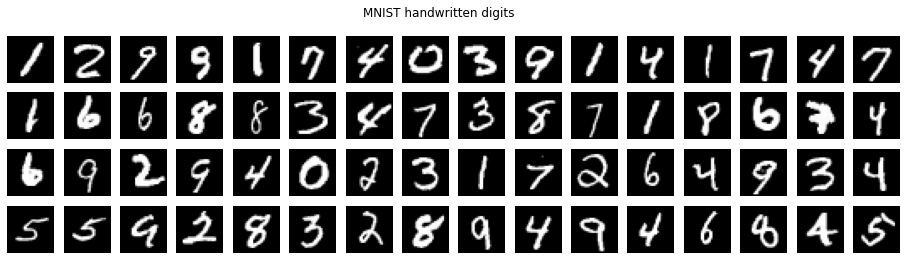

In [5]:
# plot a few MNIST examples
f, axarr = plt.subplots(4, 16, figsize=(16, 4))

# Load a batch of images into memory
images, labels = next(iter(train_dataloader))

for i, ax in enumerate(axarr.flat):
    ax.imshow(images[i].view(28, 28), cmap="binary_r")
    ax.axis("off")

plt.suptitle("MNIST handwritten digits")
plt.show()

Define a Variational Autoencoder by formulating the encoder to describe a probability distribution for each latent attribute. The latent dimension is characterized by mean and variance for each latent attribute.  

During the forward pass, you can use the `torch.chunk` function to split the latent layer to mean and variance vectors.  

Use the reparametrization trick suggested in the [VAE paper](https://arxiv.org/pdf/1312.6114.pdf) for sampling the latent dimension for input to the decoder. (This is needed because you can not backprob through a random node)

In [12]:
# define size of image features
# For MNIST data, we flatten the 28x28 image
num_input_features = 28 ** 2


class VariationalAutoEncoder(nn.Module):
    def __init__(self, num_latent_features):
        super().__init__()

        self.num_latent_features = num_latent_features
        
        # Encode the data onto the latent space using two linear layers
        self.encoder = nn.Sequential(
            nn.Linear(in_features=num_input_features, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=2 * self.num_latent_features),
        )

    # Decode latent information into the original image
        self.decoder = nn.Sequential(
            nn.Linear(in_features=self.num_latent_features, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=num_input_features),
            nn.Sigmoid(),     #Convert outputs to the scale of the inputs, ie, [0, 1]
        )
       
    def reparametrisation(self, mu, log_var):
        # N(mu, sigma) = mu + epsilon * sigma, where epsilon ~ N(0, 1)
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        sample = mu + eps * std
        return sample

    def forward(self, x):
        outputs = {}

        # Split encoder outputs into a mean and variance vector
        mu, log_var = torch.chunk(self.encoder(x), 2, dim=-1)

        z = self.reparametrisation(mu, log_var)

        # Run through decoder
        x = self.decoder(z)

        outputs["x_out"] = x
        outputs["z"] = z
        outputs["mu"] = mu
        outputs["log_var"] = log_var

        return outputs

In [13]:
num_latent_features = 10
vae_model = VariationalAutoEncoder(num_latent_features).to(device)
print(vae_model)

VariationalAutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=20, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=784, bias=True)
    (5): Sigmoid()
  )
)


### Construct the loss function

To ensure that the approximate learned distribution $q(z|x)$ is similar to $p(z|x)$, we minimize the KL divergence between the two distributions.  

$\min K L(q(z \mid x) \| p(z \mid x))$  

We can minimize the above expression by maximizing the following:  
$\mathcal{L}(x) = \mathbb{E}_{q(z|x)} \left[\log p(x|z)\right] - \mathbb{E}_{q(z|x)}\left[\log \frac{q(z|x)}{p(z)}\right] = \mathbb{E}_{q(z|x)} \left[\log p(x|z)\right] - KL[q(z|x) || p(z)]$

The first term represents the reconstruction likelihood and the second term ensures that our learned distribution $q$ is similar to the true prior distribution $p$. The KL-term can be calculated analytically and for the reconstruction error, $\log p(x|z)$, we can use the binary cross-entropy error.

In [14]:
def ELBO_loss(x_out, x, mu, log_var):
    BCE = binary_cross_entropy(x_out, x, reduction="sum")
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    loss = BCE + KLD
    return loss


vae_lr = 0.001
vae_optimizer = optim.Adam(vae_model.parameters(), lr=vae_lr)
vae_loss_function = ELBO_loss

### Train the model

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 1 Average Training loss: 104.0446 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 104.7839 =======


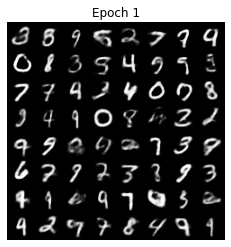

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 2 Average Training loss: 103.8879 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 104.6425 =======


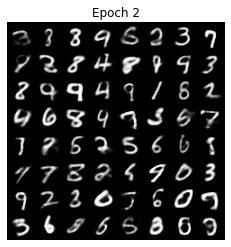

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 3 Average Training loss: 103.8376 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 104.6545 =======


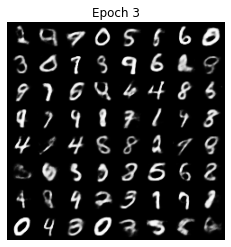

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 4 Average Training loss: 103.6832 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 104.5648 =======


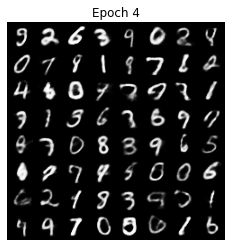

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 5 Average Training loss: 103.6116 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 104.7073 =======


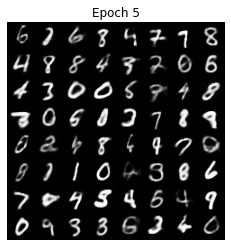

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 6 Average Training loss: 103.5238 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 104.8072 =======


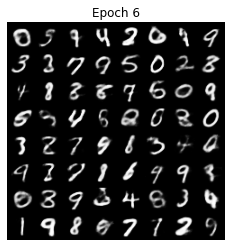

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 7 Average Training loss: 103.4735 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 104.3607 =======


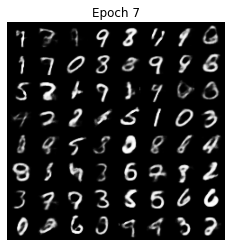

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 8 Average Training loss: 103.3212 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 104.1441 =======


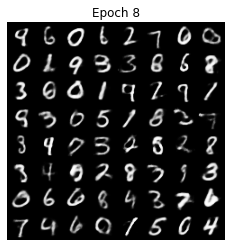

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 9 Average Training loss: 103.2804 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 104.3651 =======


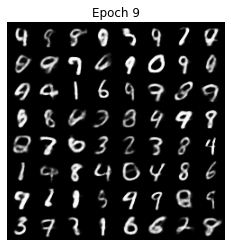

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 10 Average Training loss: 103.1921 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 104.1220 =======


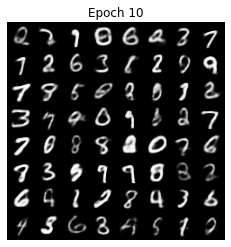

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 11 Average Training loss: 103.1114 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 104.6791 =======


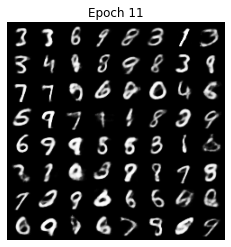

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 12 Average Training loss: 103.0593 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 104.0502 =======


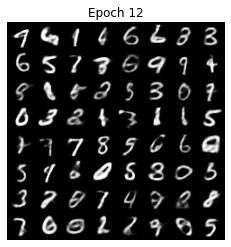

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 13 Average Training loss: 102.9877 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 104.3748 =======


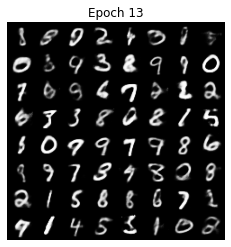

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 14 Average Training loss: 102.9143 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 104.3349 =======


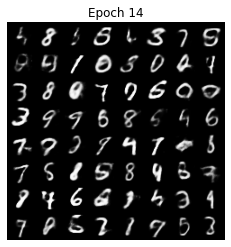

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 15 Average Training loss: 102.8589 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 103.8374 =======


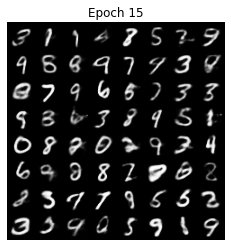

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 16 Average Training loss: 102.7900 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 103.8302 =======


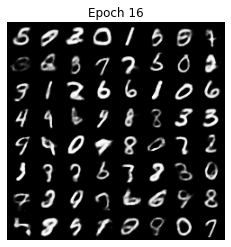

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 17 Average Training loss: 102.7094 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 104.0112 =======


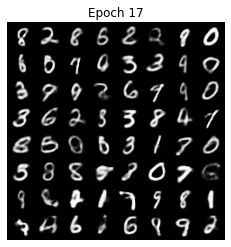

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 18 Average Training loss: 102.6922 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 104.0140 =======


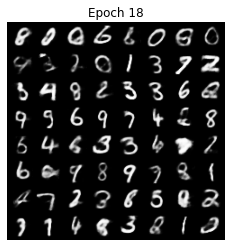

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 19 Average Training loss: 102.6222 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 104.0270 =======


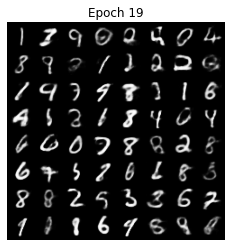

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 20 Average Training loss: 102.5817 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 104.0481 =======


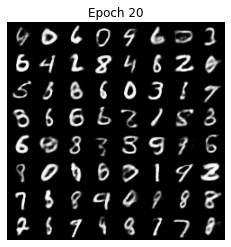

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 21 Average Training loss: 102.4818 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 103.9517 =======


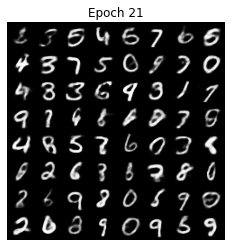

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 22 Average Training loss: 102.4668 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 104.0005 =======


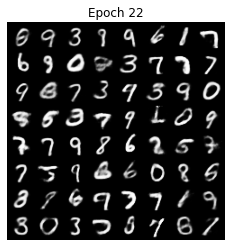

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 23 Average Training loss: 102.3629 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 104.1548 =======


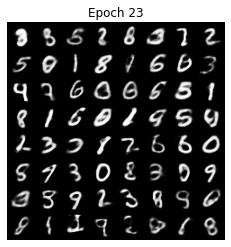

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 24 Average Training loss: 102.3774 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 103.6801 =======


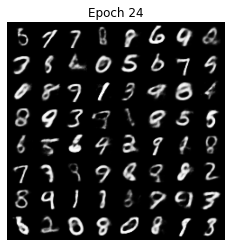

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 25 Average Training loss: 102.3391 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 103.5946 =======


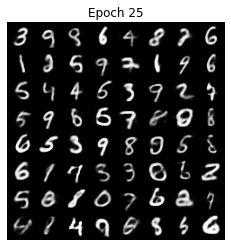

In [16]:
num_epochs = 25

train_loss_list = []
test_loss_list = []

for epoch in range(1, num_epochs + 1):
    ### =====TRAINING=====
    vae_model.train()
    train_loss = 0
    with tqdm(train_dataloader, unit="batch") as train_epoch_pbar:
        for data, labels in train_epoch_pbar:
            train_epoch_pbar.set_description(f"Epoch {epoch}")

            data = data.to(device)
            vae_optimizer.zero_grad()
            outputs = vae_model(data)
            loss = vae_loss_function(
                outputs["x_out"], data, outputs["mu"], outputs["log_var"]
            )
            loss.backward()
            vae_optimizer.step()

            train_loss += loss.item()
            avg_batch_loss = loss.item() / len(data)
            train_epoch_pbar.set_postfix(loss=avg_batch_loss)

        avg_epoch_loss = train_loss / len(train_dataloader.dataset)
        print(
            f"======= Epoch: {epoch} Average Training loss: {avg_epoch_loss:.4f} ======="
        )
    train_loss_list.append(avg_epoch_loss)

    ### =====TESTING=====
    vae_model.eval()
    test_loss = 0
    with torch.no_grad():
        with tqdm(test_dataloader, unit="batch") as test_pbar:
            for data, labels in test_pbar:
                data = data.to(device)
                outputs = vae_model(data)
                loss = vae_loss_function(
                    outputs["x_out"], data, outputs["mu"], outputs["log_var"]
                )
                test_loss += loss.item()

    test_loss /= len(test_dataloader.dataset)
    print(f"======= Test set loss: {test_loss:.4f} =======")
    test_loss_list.append(test_loss)

    # Visualizing training progress
    with torch.no_grad():
        sample = torch.randn(batch_size, num_latent_features).to(device)
        sample = vae_model.decoder(sample).detach().cpu()
        image_grid = make_grid(sample.view(batch_size, 1, 28, 28), nrow=8).permute(
            1, 2, 0
        )
        plt.imshow(image_grid.numpy(), cmap="gray", vmin=0, vmax=255)
        plt.axis("off")
        plt.title(f"Epoch {epoch}")
        plt.show()

### Plot the training loss values

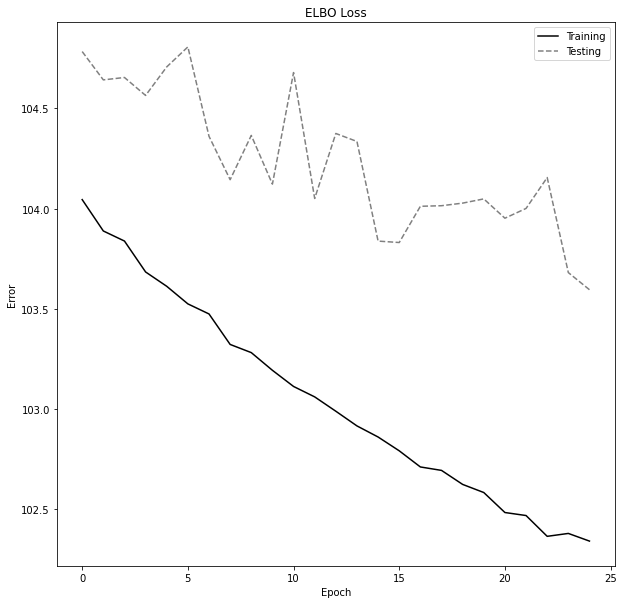

In [17]:
# Plotting
f, axarr = plt.subplots(1, 1, figsize=(10, 10))

# Loss
ax = axarr
ax.set_title("ELBO Loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Error")

ax.plot(np.arange(num_epochs), train_loss_list, color="black")
ax.plot(np.arange(num_epochs), test_loss_list, color="gray", linestyle="--")
ax.legend(["Training", "Testing"])

### Visualizing input data and its reconstruction from model

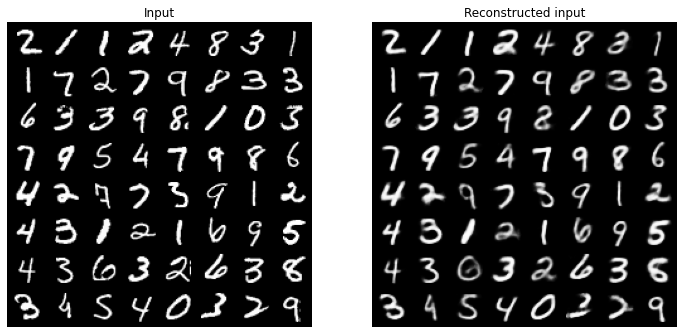

In [18]:
f, axarr = plt.subplots(1, 2, figsize=(12, 12))

with torch.no_grad():
    x, _ = next(iter(train_dataloader))
    x = Variable(x)
    x = x.to(device)
    outputs = vae_model(x)
    x_out = outputs["x_out"].detach().cpu()
    x = x.detach().cpu()

    image_grid = make_grid(x.view(batch_size, 1, 28, 28), nrow=8).permute(1, 2, 0)
    axarr[0].imshow(image_grid.numpy())
    axarr[0].set_title("Input")
    axarr[0].axis("off")

    image_grid = make_grid(x_out.view(batch_size, 1, 28, 28), nrow=8).permute(1, 2, 0)
    axarr[1].imshow(image_grid.numpy())
    axarr[1].set_title("Reconstructed input")
    axarr[1].axis("off")

### Visualize Embedding

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


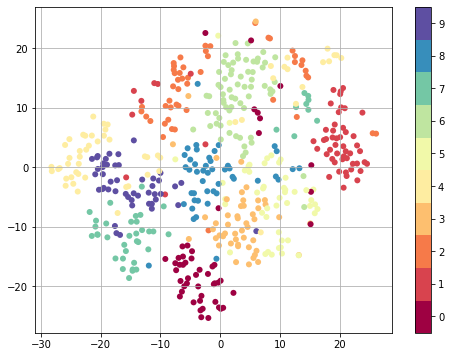

In [21]:
# Increase the batch size for a nicer plot
dataloader = DataLoader(dset_train, batch_size=512, shuffle=True)
visualize_embeddings(vae_model, dataloader)